In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np

In [2]:
#first step is to calculate moving average and moving standard deviation
#we plus/minus two standard deviations on moving average
#we get our upper, mid, lower bands
def bollinger_bands(df):
    
    data=copy.deepcopy(df)
    data['std']=data['price'].rolling(window=20,min_periods=20).std()
    data['mid band']=data['price'].rolling(window=20,min_periods=20).mean()
    data['upper band']=data['mid band']+2*data['std']
    data['lower band']=data['mid band']-2*data['std']
    
    return data

In [3]:
#smoothed moving average
def smma(series,n):
    
    output=[series[0]]
    
    for i in range(1,len(series)):
        temp=output[-1]*(n-1)+series[i]
        output.append(temp/n)
        
    return output

In [4]:
rsi_period = 14
def rsi(data,n=rsi_period):
    
    delta=data.diff().dropna()
    
    up=np.where(delta>0,delta,0)
    down=np.where(delta<0,-delta,0)
    
    rs=np.divide(smma(up,n),smma(down,n))
    
    output=100-100/(1+rs)
    
    return output[n-1:]

In [8]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
# Change index to perform analysis
data = web.DataReader('^NDX',data_source='yahoo',start='10/01/2007', end='10/01/2009')['Adj Close']

In [6]:
# Consider today's close price projection in to analysis
# data[datetime.now().replace(hour=0,minute=0,second=0,microsecond=0)] = 7400
# data[(datetime.now()+ timedelta(days=1)).replace(hour=0,minute=0,second=0,microsecond=0)] = 7700
# data[(datetime.now()+ timedelta(days=2)).replace(hour=0,minute=0,second=0,microsecond=0)] = 7600

In [ ]:
#limit unitl
# data = data.loc[data.index<'2010-01-01'] 

C:\Users\junha\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


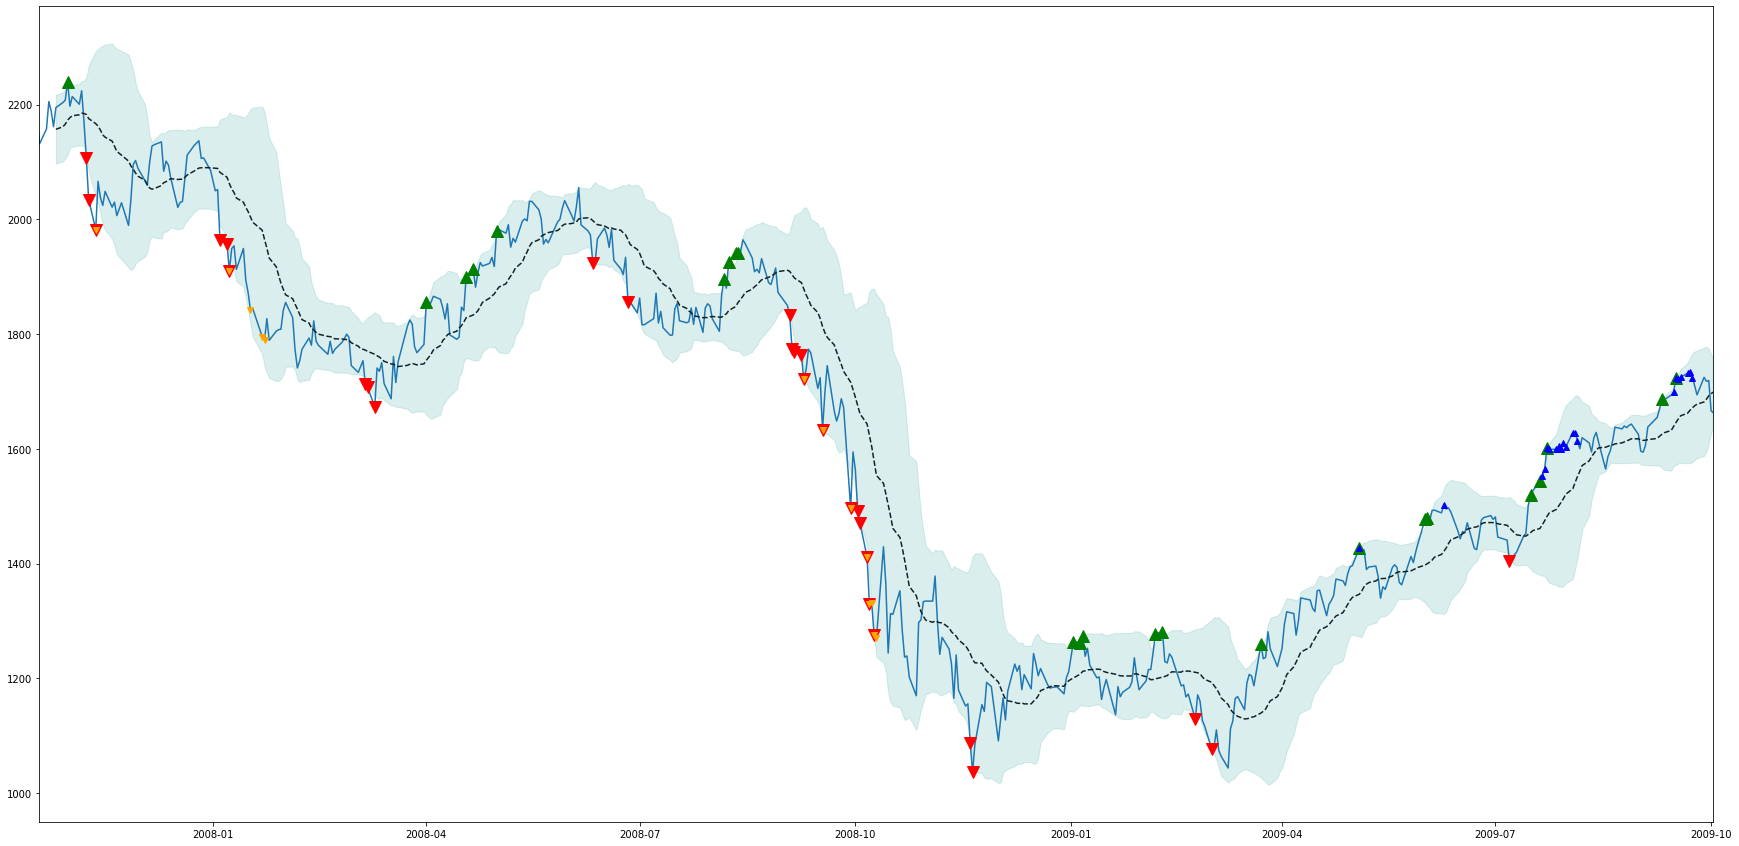

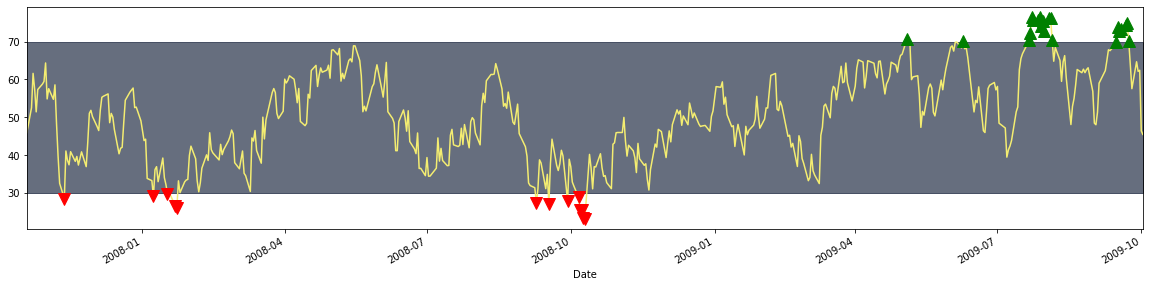

In [9]:
df=pd.DataFrame()
df['price'] = data
df = bollinger_bands(df)

df['signals'] = np.where(df['upper band'] < df['price'], 1,0 )
df['signals'] = np.where(df['lower band'] > df['price'], -1,df['signals'] )

#RSI
df['rsi'] = 0
df['rsi'][rsi_period:] = rsi(df['price'])

df['rsi_signals'] = np.where(df['rsi'] > 70, 1,0 )
df['rsi_signals'] = np.where((df['rsi'] < 30) & (df['rsi'] > 0), -1, df['rsi_signals'] )

fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(111)
    
#plotting positions on price series and bollinger bands
ax.plot(df['price'],label='price')
ax.fill_between(df.index,df['lower band'],df['upper band'],alpha=0.2,color='#45ADA8')
ax.plot(df['mid band'],linestyle='--',label='moving average',c='#132226')
ax.plot(df['price'][df['signals']==1],marker='^',markersize=12, \
            lw=0,c='g',label='LONG')
ax.plot(df['price'][df['signals']==-1],marker='v',markersize=12, \
            lw=0,c='r',label='SHORT')

ax.plot(df['price'][df['rsi_signals']==1],marker='^',markersize=6, \
            lw=0,c='blue',label='RSI_LONG')
ax.plot(df['price'][df['rsi_signals']==-1],marker='v',markersize=6, \
            lw=0,c='orange',label='RSI_SHORT')


bx=plt.figure(figsize=(20,10)).add_subplot(212,sharex=ax)
    
df[rsi_period:]['rsi'].plot(label='relative strength index',c='#f4ed71')
    
#we plot the overbought/oversold interval, positions and pattern
bx.fill_between(df.index,30,70,alpha=0.6,label='overbought/oversold range',color='#000d29')
bx.plot(df['rsi'][rsi_period:][df[rsi_period:]['rsi_signals']==1],marker='^',markersize=12, \
            lw=0,c='g',label='LONG')
bx.plot(df['rsi'][rsi_period:][df[rsi_period:]['rsi_signals']==-1],marker='v',markersize=12, \
            lw=0,c='r',label='SHORT')